### 1.0 look for the triggers that we have

In [21]:
pip install uproot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import uproot
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

# Caminho para o arquivo root
file_path = "/data/prod/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14300/V1-Hrec_hoft_16384Hz_OMICRON-1430000222-99903.root"

# Abre o arquivo
file = uproot.open(file_path)

# Lista as "árvores" (trees) disponíveis
print(file.keys())


['triggers;1', 'metadata;1', 'segments;1', 'gwloptions;1']


In [5]:
# Acessa a árvore "triggers"
tree = file["triggers"]

# Carrega os arrays como dataframe
df = tree.arrays(library="pd")

# Visualiza as primeiras linhas
print(df.head())

           time   frequency          q       snr        tstart          tend  \
0  1.430000e+09  982.471949  72.477966  5.061435  1.430000e+09  1.430000e+09   
1  1.430000e+09  996.640790  38.073079  5.081928  1.430000e+09  1.430000e+09   
2  1.430000e+09  970.000544  38.073079  5.249208  1.430000e+09  1.430000e+09   
3  1.430000e+09  996.640790  38.073079  5.910853  1.430000e+09  1.430000e+09   
4  1.430000e+09  982.471949  72.477966  5.171491  1.430000e+09  1.430000e+09   

       fstart         fend     amplitude     phase  tstart_us  
0  975.510012   989.483572  1.168377e-22 -1.346908     621094  
1  983.230445  1010.234039  1.152971e-22 -1.208132     623047  
2  956.948658   983.230445  1.177377e-22 -0.908656     625000  
3  983.230445  1010.234039  1.341034e-22 -1.248125     625000  
4  975.510012   989.483572  1.193782e-22 -1.392042     625000  


In [3]:
df['time'][0]

1430000227.623047

In [26]:
'''
import sys
import os

# Caminho absoluto para a pasta "src" dentro de PythonVirgoTools
src_path = os.path.abspath("PythonVirgoTools/src")

if src_path not in sys.path:
    sys.path.append(src_path)
'''

In [ ]:
import lal
from lal import LIGOTimeGPS

### 1.2 Acessing Virgo data in Cascina

In [28]:
pip install pythonvirgotools

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
from virgotools import getChannel
import matplotlib.pyplot as plt

# Some (useless) customizations

plt.rcParams.update({
 'axes.labelsize': 9,
 'xtick.labelsize': 9,
 'ytick.labelsize': 9,
 'grid.color': 'gray',
 'font.size': 9,
 'font.family': 'serif',
 'savefig.dpi': 180,
 'legend.fontsize': 9,
 'grid.alpha': .3,
 "mathtext.fontset": "cm",
})

# The following is a "magic function" that select the backend of iPython. It will results later:
%matplotlib inline

In [8]:
# gps = 1414713610
gps = 1430000227.623047
ch = "V1:Hrec_hoft_16384Hz"
FrV = getChannel(ch, gps, 10)

In [9]:
print(f"This is the name of the channel: {FrV.name}\nand these are its units: {FrV.unit}")

This is the name of the channel: V1:Hrec_hoft_16384Hz
and these are its units: strain


In [10]:
from gwpy.time import to_gps, from_gps

gps = to_gps("2023-12-25 12:00").gpsSeconds

In [11]:
print(gps)

1387540818


In [13]:
from gwpy.timeseries import TimeSeries

def FrV_to_TS(frV):
    """Convert FrVect objects to gwpy TimeSeries
    Parameters
    ----------
    frV : `virgotools.FrVect`
    Python virgotools frame vector
    Returns
    -------
    TimeSeries
    GWpy TimeSeries corresponding to ``frV``
    """
    from astropy.units import Unit, dimensionless_unscaled
    try:
        unit = Unit(frV.unit)
    except:
        unit = dimensionless_unscaled
    
    return TimeSeries(data=frV.data, t0=frV.gps, sample_rate=frV.fsample, unit=unit, channel=frV.name)

In [15]:
TS = FrV_to_TS(FrV)

In [16]:
type(TS)

gwpy.timeseries.timeseries.TimeSeries

In [17]:
print(TS)

TimeSeries([3.46673401e-18, 3.53050446e-18, 3.52883108e-18, ...,
            1.00483099e-18, 1.60283956e-18, 1.11328874e-18]
           unit: strain,
           t0: 1430000227.6230469 s,
           dt: 6.103515625e-05 s,
           name: None,
           channel: V1:Hrec_hoft_16384Hz)


In [18]:
def read2TS(*args, **kwargs):

    """
    This funtion has the same exact parameters as `virgotools` `getChannel` but␣
    ↪it returns a `TimeSeries`.
    """
    with getChannel(*args, **kwargs) as frv:
        return FrV_to_TS(frv)

### 1.3 Plot time series data

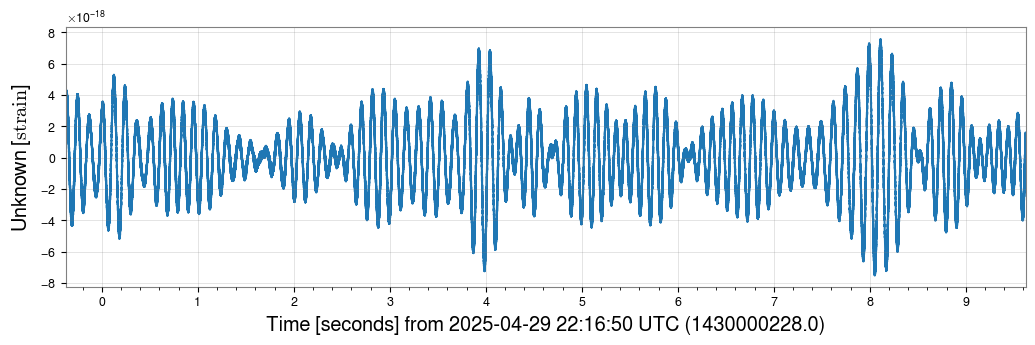

In [19]:
TS.plot();

/cvmfs/software.igwn.org/conda/envs/igwn-py39-20231219/lib/python3.9/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


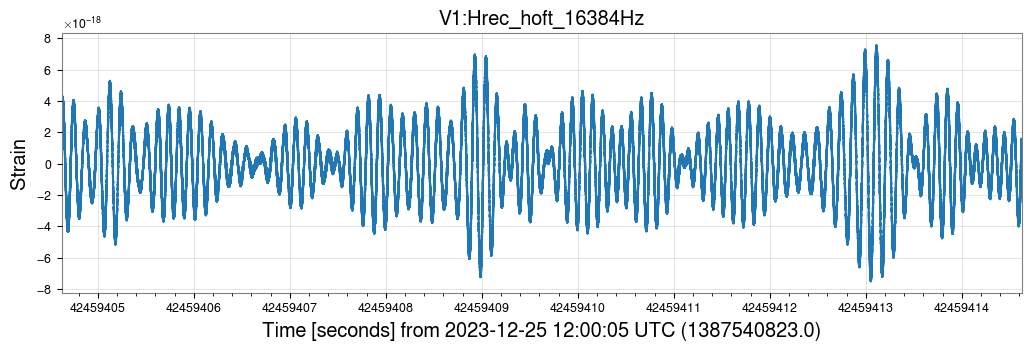

In [20]:
plot = TS.plot()
ax = plot.gca()
ax.set(ylabel="Strain", title=TS.channel.name, epoch=gps+5)
plot.show()

### 1.4 Read trend data

In [21]:
bns_ch = "V1:Hrec_Range_BNS"
bnsTS = read2TS("trend", bns_ch, gps, 3600)

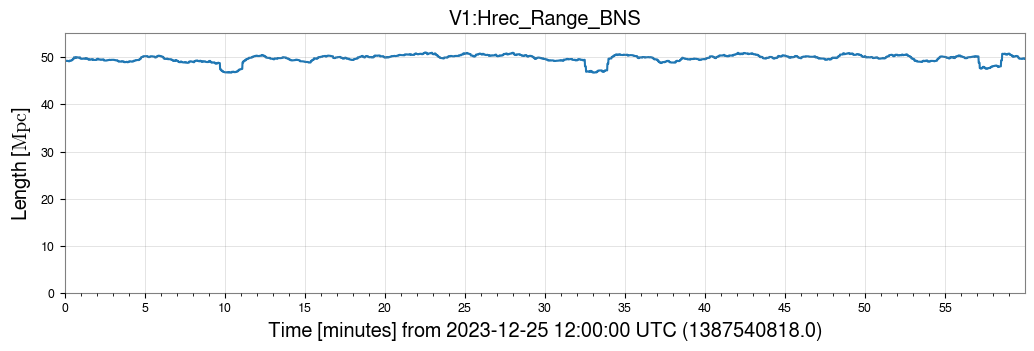

In [22]:
bnsTS.plot(title=bnsTS.channel.name, ylim=(0,55));

### 1.5 Data Quality Flags

In [23]:
chDQ = "V1:META_ITF_LOCK_index"
start = to_gps("2023-12-24 16:00").gpsSeconds
end = to_gps("2024-01-01 12:00").gpsSeconds
DQTS = read2TS("trend", chDQ, start, end)

In [24]:
state_val = 135
sTS = DQTS >=state_val
DQ = sTS.to_dqflag(label="Low Noise")

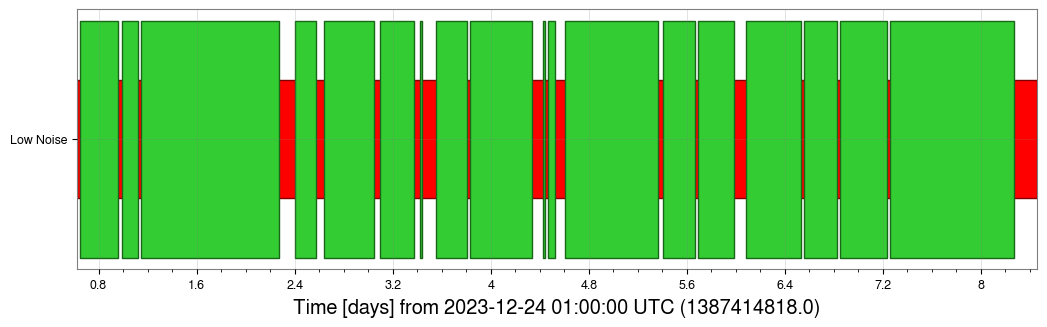

In [25]:
DQ.plot();

In [26]:
bnsTS = read2TS("trend", bns_ch, start, end)

/cvmfs/software.igwn.org/conda/envs/igwn-py39-20231219/lib/python3.9/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


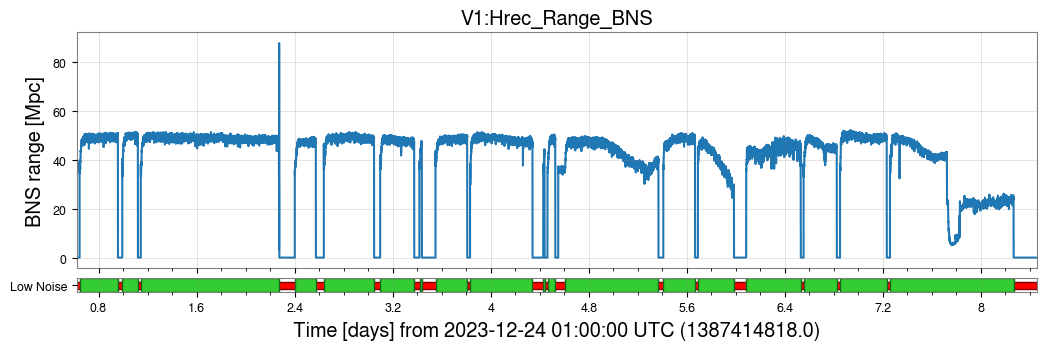

In [27]:
plot = bnsTS.plot(title=bnsTS.channel.name, ylabel="BNS range [Mpc]")
ax = plot.gca()
plot.add_segments_bar(DQ, ax=ax, pad=.1, height=.14)
plot.show()